# Visualização da Distribuição dos Prazos

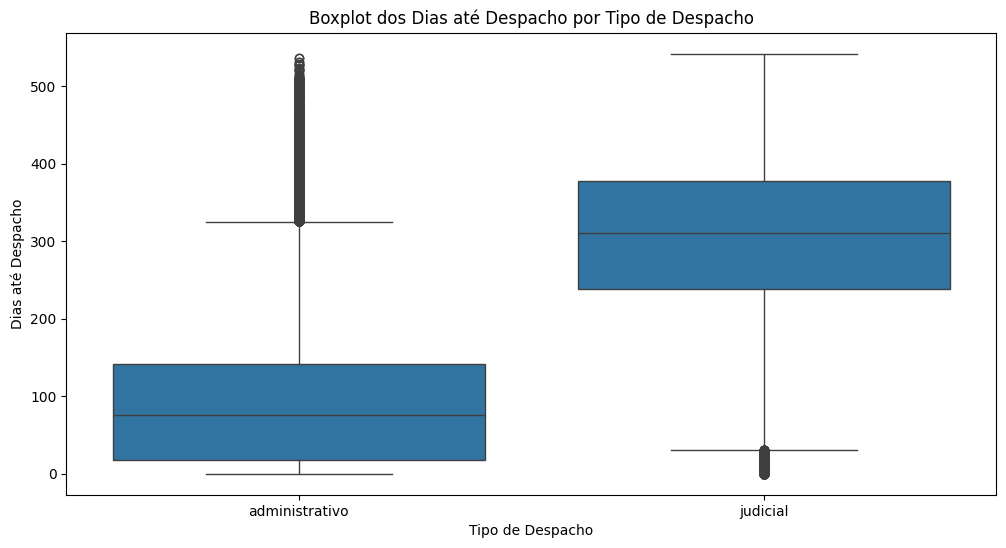

In [0]:
df_spark = spark.sql("""
  SELECT 
    competencia,
    tipo_despacho,
    dias_ate_despacho
  FROM portfolio_inss.silver.silver_bpc_concessoes
  WHERE dt_inicio_beneficio >= '2024-01-01'
""")

df = df_spark.toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(x='tipo_despacho', y='dias_ate_despacho', data=df)
plt.title('Boxplot dos Dias até Despacho por Tipo de Despacho')
plt.xlabel('Tipo de Despacho')
plt.ylabel('Dias até Despacho')
plt.show()


In [0]:
df.groupby('tipo_despacho')['dias_ate_despacho'].describe() 


,count,mean,std,min,25%,50%,75%,max
tipo_despacho,,,,,,,,
administrativo,311919.0,91.881058,83.529625,0.0,18.0,76.0,141.0,537.0
judicial,56026.0,304.833252,102.591927,0.0,239.0,311.0,378.0,542.0


### Análise da Distribuição do Prazo

A distribuição dos prazos no grupo **administrativo** revela que:

- Até o **25%(Q1)** dos dados, a variação dos prazos é relativamente pequena e concentrada.
- Entre o **25%(Q1) e 50%(Q2)** e também até o **75%(Q3)**, a variação aumenta, mas ainda de forma moderada.
- Já nos últimos **25% dos dados** (o quartil superior), a variação se torna muito mais expressiva, indicando uma cauda longa.

Além disso, há uma grande quantidade de **outliers**, ou valores atípicos, que se destacam além do intervalo esperado.

Por conta dessa dispersão e dos outliers, a **média acaba sofrendo um viés significativo**, tornando-se uma medida menos confiável para representar o prazo típico.

Nesse cenário, a **mediana se mostra uma métrica mais robusta e confiável**, pois é menos sensível a valores extremos e oferece uma melhor representação do prazo central.

A distribuição dos prazos no grupo **judicial** revela que:

- Diferentemente do grupo administrativo, o judicial demonstra uma maior uniformidade nos prazos.  
- Os quartis indicam uma distribuição próxima da normal, sem discrepâncias significativas entre eles.  
- Há presença de outliers, porém em menor quantidade e de forma mais tímida, principalmente no limite inferior.  

Dessa forma, a **média pode ser utilizada com segurança**, pois não há distorções significativas, tornando-a uma medida confiável para representar o prazo típico nesse grupo.


# Interpretação da Distribuição

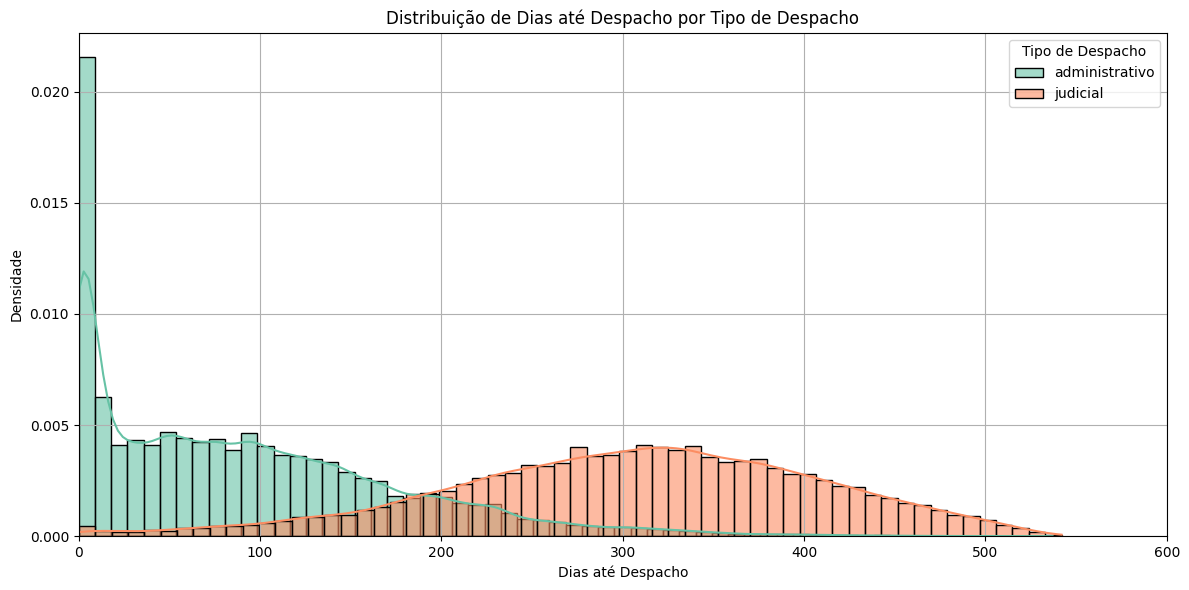

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

cores = {
    'administrativo': '#66c2a5',
    'judicial': '#fc8d62'
}


for tipo, cor in cores.items():
    subset = df[df['tipo_despacho'] == tipo]
    sns.histplot(
        subset['dias_ate_despacho'],
        bins=60,
        kde=True,
        stat='density',
        color=cor,
        label=tipo,
        alpha=0.6
    )

plt.title('Distribuição de Dias até Despacho por Tipo de Despacho')
plt.xlabel('Dias até Despacho')
plt.ylabel('Densidade')
plt.xlim(0, 600)
plt.grid(True)

plt.legend(title='Tipo de Despacho')
plt.tight_layout()
plt.show()


In [0]:
df.groupby("tipo_despacho")["dias_ate_despacho"].skew()

## Análise de Tendência Central: Média ou Mediana?



###  1. **Skewness (Assimetria)**

- Valores próximos de **0** indicam **distribuição simétrica**.
- Valores **maiores que 1 ou menores que -1** indicam **assimetria forte**.

###  2. **Análise Visual**
- **Cauda longa à direita** → Assimetria **positiva** → **Use mediana**
- **Distribuição simétrica** → Pode usar **média**

---

###  Interpretação dos Valores de Skewness

| Tipo de despacho  | Skewness | Interpretação                                 | Implicação                                      |
|-------------------|----------|-----------------------------------------------|-------------------------------------------------|
| Administrativo    | **+0.996** | Assimetria positiva moderada a forte          | A média é puxada para cima → **Use a mediana**  |
| Judicial          | **−0.403** | Assimetria negativa leve                      | Distribuição razoavelmente simétrica → **Pode usar média ou mediana** |



---
Após compreender a dinâmica geral dos prazos por tipo de despacho, exploramos também o tipo de benefício (Idoso e Pessoa com Deficiência) com o objetivo de verificar se há diferenças estruturais relevantes que poderiam influenciar os resultados anteriores. Essa análise atua como uma etapa de validação e reforço da nossa interpretação.


## Visualização da Distribuição dos Prazos por Tipo de Despacho e Benefício

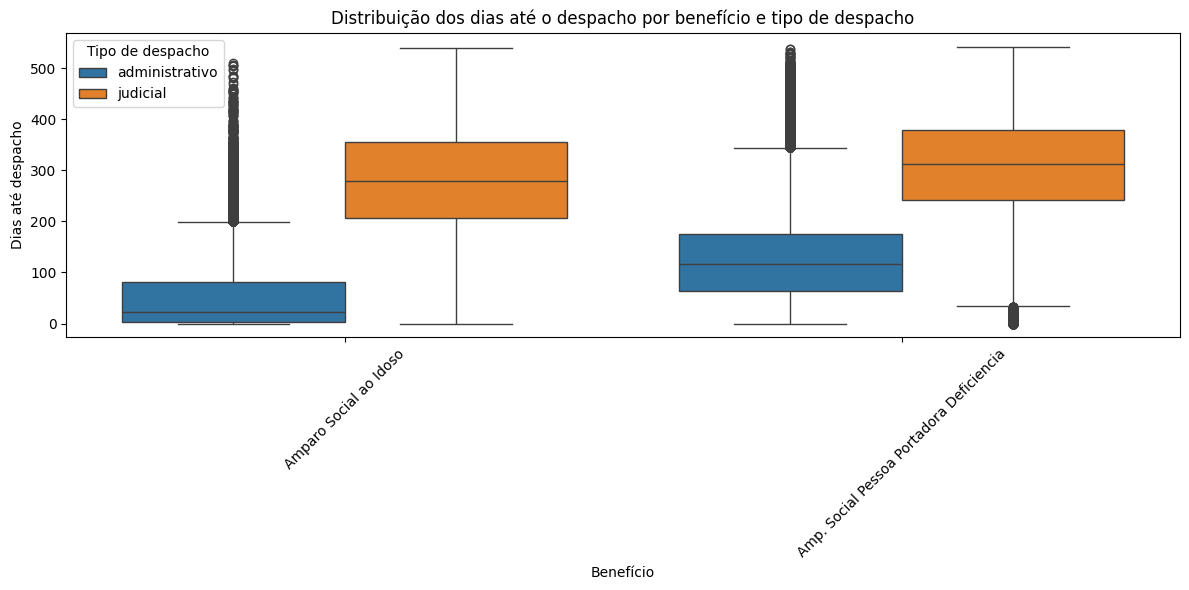

In [0]:
df_spark = spark.sql("""
  SELECT 
    competencia,
    beneficio,
    tipo_despacho,
    dias_ate_despacho
  FROM portfolio_inss.silver.silver_bpc_concessoes
  WHERE dt_inicio_beneficio >= '2024-01-01'
""")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df_pandas = df_spark.toPandas()

df_pandas = df_pandas.dropna(subset=['dias_ate_despacho'])

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_pandas,
    x='beneficio',
    y='dias_ate_despacho',
    hue='tipo_despacho'
)

plt.title('Distribuição dos dias até o despacho por benefício e tipo de despacho')
plt.xlabel('Benefício')
plt.ylabel('Dias até despacho')
plt.legend(title='Tipo de despacho')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [0]:
# Administrativo
df_adm = df_pandas[df_pandas['tipo_despacho'] == 'administrativo']
desc_adm = df_adm.groupby('beneficio')['dias_ate_despacho'].describe()
print(desc_adm.T)  # Transposto para facilitar a leitura

beneficio  Amp. Social Pessoa Portadora Deficiencia  Amparo Social ao Idoso
count                                 167527.000000           144392.000000
mean                                     128.538986               49.349644
std                                       83.693390               59.811512
min                                        0.000000                0.000000
25%                                       64.000000                2.000000
50%                                      117.000000               22.000000
75%                                      176.000000               81.000000
max                                      537.000000              511.000000


In [0]:
# Judicial
df_judicial = df_pandas[df_pandas['tipo_despacho'] == 'judicial']
desc_jud = df_judicial.groupby('beneficio')['dias_ate_despacho'].describe()
print(desc_jud.T)  # Transposto para facilitar a leitura


beneficio  Amp. Social Pessoa Portadora Deficiencia  Amparo Social ao Idoso
count                                  52077.000000             3949.000000
mean                                     306.891479              277.690796
std                                      101.982849              106.670250
min                                        0.000000                0.000000
25%                                      241.000000              206.000000
50%                                      313.000000              279.000000
75%                                      379.000000              355.000000
max                                      542.000000              540.000000


## Análise dos Prazos por Tipo de Despacho e Benefício

Ao analisar os prazos no âmbito administrativo e judicial, considerando o benefício BPC para Idoso e Pessoa com Deficiência, o objetivo é destrinchar se há distorções nos tempos de processamento entre esses grupos.

- Avaliamos se os prazos diferem significativamente entre os tipos de despacho (administrativo vs judicial).  
- Investigamos a existência de discrepâncias nos prazos entre os benefícios BPC Idoso e BPC Deficiente.  
- Buscamos compreender se essas diferenças podem indicar padrões distintos de tramitação e possíveis distorções no processo.

---
### Conclusão

**Judicial**

Para os dois tipos de benefício (**Pessoa com Deficiência** e **Idoso**), os valores de média, mediana e quartis são relativamente próximos.  
Isso sugere que o tempo médio dos processos judiciais é semelhante para esses benefícios, e a distribuição dos prazos não apresenta grandes discrepâncias entre eles.  
Ou seja, o comportamento dos prazos judiciais é mais homogêneo entre os dois grupos.



**Administrativo**

Já aqui a história é diferente. Existe uma discrepância clara entre os prazos para os dois benefícios.

- A média para **Pessoa com Deficiência** está em torno de **131 dias**, enquanto para **Idoso** é de apenas **50 dias** — uma diferença significativa.  
- Essa diferença se reflete também nos quartis (25%, 50%, 75%), mostrando que não é um problema de outliers isolados, mas sim um padrão consistente.  
- Isso indica que os processos administrativos para **Pessoa com Deficiência** tendem a levar mais tempo que para o **Idoso**.


---

>  **Conclusão prática:**  
> - Para **administrativo**, a **mediana** é mais representativa.  
> - Para **judicial**, a **média** é aceitável, mas a **mediana** continua sendo mais robusta, especialmente se houver outliers.
